## Objectives:

 * Learn how to plot with multiple panels
 * Learn how to add a unified colorbar to plots
 * Learn techniques for generating publication qualitfy figures
 
This lesson duplicates Week 5 Lesson 2, but using `cartopy` instead of `basemap` for geospatial plotting.  I do this partly because I realized as Python and matplotlib have advanced, `basemap` has not been updated in 3 years and makes use of matplotlib and python features that are no longer well-supported, which leads to unexpected (and hard to track down) bugs.

Note that I am new to `cartopy`, so there may be better ways to do some of this.

This notebook explores using advanced plotting techniques to plot geospatial data.  It involves use of the `cartopy` module, which can be installed by running `conda install -c scitools cartopy` from the Anaconda Prompt (or the command line).

In this specific example, I demonstrate plotting a publication-quality 4-panel figure showing a snapshot of precipitation from an observation dataset (PERSIANN) and 3 climate model hindcasts.

In [8]:
"""Load necessary libraries"""
# import the sys library for setting where scripts can import from
import sys

# add the netCDF library
import netCDF4 as nc

# import plotting libraries
import pylab as PP
import matplotlib as mpl

# import a custom library for generating a grid of boxes from which to select data; used here to generate
# polygons for drawing.
# this can be downloaded at https://taobrienucd.bitbucket.io/class_scripts/genBoundingBoxes.py
sys.path.append('../class_scripts') # allow importing from the class_scripts folder
import genBoundingBoxes as gen

# import cartopy (use `conda install -s scitools cartopy` to install)
import cartopy.crs as ccrs

# import numpy
from numpy import *

# use inline plotting
%matplotlib inline

# set default fonts
font = { 'family' : 'serif', \
        'size' : '15' }
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib


# Define a helper function for lat/lon boxes on a projection
def bboxToPolygon(bbox,m,shiftLons = True):
    """Converts a bounding box from genBoundingBoxes into x,y,width,height suitable for mpl.patches.Polygon
    
       input:
       ------
       
       bbox : a tuple of lat/lon indices describing the segements of a polygon
       
       m : a Basemap instance
       
       shiftLons : flags whether to shift longitudes by -180 degrees
       
       output:
       -------
       a list of polygon coordinates suitable for mpl.patches.Polygon()
    
    """

    lat0,lat1,lon0,lon1 = bbox
    # shift longitudes
    if shiftLons:
        lon0 -= 180
        lon1 -= 180

    # Generate the list of polygon segments
    segments = [((lat0,lon0),(lat1,lon0)), \
                ((lat1,lon0),(lat1,lon1)), \
                ((lat1,lon1),(lat0,lon1)), \
                ((lat0,lon1),(lat0,lon0))]


    # use a list comprehension to do the mapping quickly
    # see below for a description of what this does
    seg_res = 10 # set the segment resolution
    xy = concatenate([ m(linspace(seg[0][1],seg[1][1],seg_res),linspace(seg[0][0],seg[1][0],seg_res)) for seg in segments],axis = 1).T
    # the above list comprehension is equivalent to the below code:
    #    ysegs = []
    #    xsegs = []
    #    # loop over each segment and generate an higher-res segement interpolated to map space
    #
    #    for seg in segments:
    #        # use the basemap instance to map a line segment from lat/lon coordinates to projection coordinates
    #        xs,ys = m(linspace(seg[0][1],seg[1][1],seg_res),linspace(seg[0][0],seg[1][0],seg_res))
    #        if xsegs == []:
    #            xsegs = xs
    #        else:
    #            xsegs = concatenate((xsegs,xs))
    #        if ysegs == []:
    #            ysegs = xs
    #        else:
    #            ysegs = concatenate((ysegs,ys))
    #
    #    #stich the segments together into an array appropriate for Polygon
    #    xy = array([array(xsegs),array(ysegs)]).T
    
    return xy

In [2]:
""" Read precip fields into a dictionary"""

itime = 0
precip = {}
# set the resolutions
resolutions = ['ne16np4','ne30np4','ne120np4']
# set file names (these files can be downloaded from):
#  https://taobrienucd.bitbucket.io/data/persiann_precip_itime_1821.nc
#  https://taobrienucd.bitbucket.io/data/iliad_precip_ne120np4_itime_1821.nc
#  https://taobrienucd.bitbucket.io/data/iliad_precip_ne30np4_itime_1821.nc
#  https://taobrienucd.bitbucket.io/data/iliad_precip_ne16np4_itime_1821.nc
iliad_file_template = '../data/iliad_precip_{res}_itime_1821.nc'
persiann_file = '../data/persiann_precip_itime_1821.nc'

#*****************
# Read in fields 
#*****************
# read in the PERSIANN field
with nc.Dataset(persiann_file,'r') as fin:
    precip_persiann = fin.variables['precipitation'][0,...]
    lat = fin.variables['lat'][:]
    lon = fin.variables['lon'][:]

# store the precip field
precip['PERSIANN'] = precip_persiann
    
# loop over resolutions
for res in resolutions:
    # set the iliad file name
    iliad_file = iliad_file_template.format(res=res)
    
    # read in the ILIAD field
    with nc.Dataset(iliad_file,'r') as fin:
        precip_iliad = fin.variables['PRECT'][0,...]
        
    # store in the dictionary and convert to mm/day
    precip[res] = precip_iliad*8.64e7
    #zero-out negative values that resulted from the interpolation
    i_less_zero = where(precip[res] < 0)
    precip[res][i_less_zero] = 0.0

# produce 2D lat/lon arrays
xlat,xlon = meshgrid(lat,lon)
xlat = ascontiguousarray(xlat.T)
xlon = ascontiguousarray(xlon.T)

In [3]:
""" Get the bounding boxes used by the pairedEvents routine """
latBoxSize = 20
lonBoxSize = 20
resolution = 2
#Generate bounding boxes
latIndSize = int(latBoxSize/resolution)
lonIndSize = int(lonBoxSize/resolution)
bboxes = gen.genBoundingBoxes(lat,lon,latIndSize,lonIndSize)

AttributeError: module 'cartopy.crs' has no attribute 'Robinson'

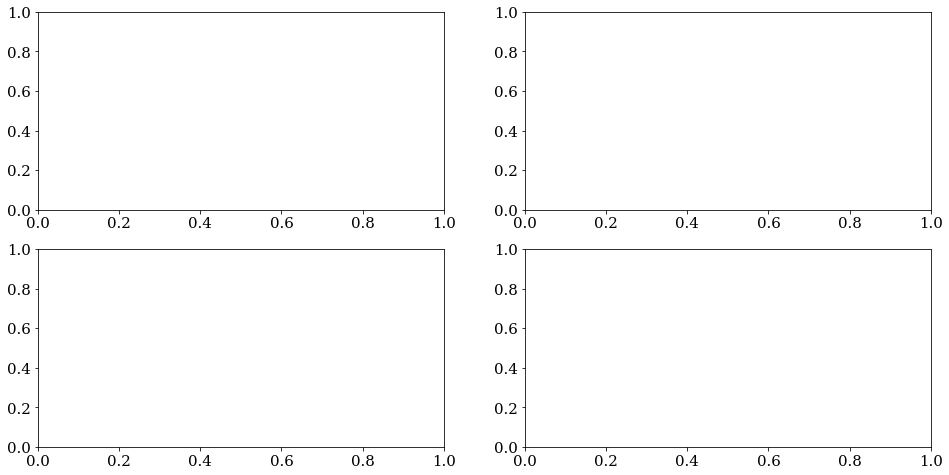

In [7]:
"""Generate a pub-quality precip figure"""

# set the dictionary keys over which we will iterate
models = ['PERSIANN','ne16np4','ne30np4','ne120np4']
# set the color of map lines (semi-transparent black)
mapLineColor = [0,0,0,0.5]
# set the labels of the plots
panel_labels = ['(a)','(b)','(c)','(d)']


# initialize the plot with a 2x2 subpanel
fig,axs = PP.subplots(2,2,figsize=(16,8))

# create a mapping between linear axis index and subpanel location
ax_grid = [(0,0),(0,1),(1,0),(1,1)]

# loop over the models
for i,key in enumerate(models):
    # select the current axis on which to plot
    ax = axs[ax_grid[i]]
    
    # initialize the map using the 'robinson' projection, whcih truncates at the poles
    # center the longitude at the mid-point of the map
    center_lon = 0.5*(lon[0]+lon[-1])
    projection = cartopy.crs.Robinson(center_lon)

    
    #Draw the plot
    if key == 'PERSIANN':
        # draw a contour plot of the PERSIANN data with 64 levels and the 'Set1_r' colormap
        cplot = ax.contourf(xlon,xlat,precip[key],64,transform=projection,cmap='Set1_r')
    else:
        # draw a contour plot of the given model, using the contour levels and colormap from the PERSIANN plot
        m.contourf(xlon,xlat,precip[key],levels=cplot.levels,transform=projection,cmap=cplot.cmap)
        
    # draw coast lines with a slightly thick line
    m.drawcoastlines(color=mapLineColor,linewidth=1.5)
    
    # draw the bounding boxes in light gray with thick/semi-transparent lines
    # note the use of a list comprehension here instead of a for-loop
    #[ax.add_patch(mpl.patches.Polygon(bboxToPolygon(bbox,m),edgecolor='gray',facecolor='none',linewidth=3,alpha=0.1)) for bbox in bboxes]

    
    # add the panel label
    ax.text(0.09, 0.01, panel_labels[i], \
            horizontalalignment='center', \
            verticalalignment='center', \
            transform=ax.transAxes, \
            weight='bold', \
            size=15)

# adjust spacing between panels and make room for the colorbar
fig.subplots_adjust(right=0.92,wspace=-0.05,hspace=0.05)

# add an axis for the master colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

# draw the colorbar
cb = fig.colorbar(cplot, cax=cbar_ax)

# set the colorbar label, orientation, and font
cb.set_label('Precipitation Rate [mm day$^{-1}$]',rotation=270,weight='bold',size=15,labelpad=25)

# set the font of the colorbar labels 
tickprop = mpl.font_manager.FontProperties(family='sans-serif',weight='bold',size=15)
for label in cb.ax.get_yticklabels():
    label.set_fontproperties(tickprop)

# save as a jpeg image with a resolution of 300 dots per inch
PP.savefig('fig_iliad.jpg',dpi=300)

PP.show()

In [9]:
import cartopy


In [10]:
help(cartopy.crs)

Help on module cartopy.crs in cartopy:

NAME
    cartopy.crs

FILE
    /home/taobrien/anaconda3/lib/python3.6/site-packages/cartopy/crs.py


